# Schema matching con i tool di Valentine

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from valentine import valentine_match
from valentine.algorithms import Coma, Cupid, DistributionBased, JaccardLevenMatcher, SimilarityFlooding
import pprint
import random
from itertools import combinations
import seaborn as sns
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np

In [2]:
datasets_base_path = "..\\..\\Dataset\\Clusters_CSV\\original\\"
plot_path = ".\\plot\\"
if os.path.exists(plot_path):
    shutil.rmtree(plot_path)
    os.mkdir(plot_path)
else:
    os.mkdir(plot_path)

### Estrazione score match fra coppie di colonne per ogni cluster

In [3]:
# res0 = {
#     (table1, column1, table2, column2): score
# }
def schema_matching(df1, df2, matcher, df1_name, df2_name):
    matches = valentine_match(df1, df2, matcher, df1_name, df2_name)
    res0 = {}
    res1 = []
    for key in matches:
        res0[(key[0][0], key[0][1], key[1][0], key[1][1])] = matches[key]    
        res1.append([matcher.__class__.__name__, key[0][0], key[0][1], key[1][0], key[1][1], matches[key]])
    return (res0, pd.DataFrame(res1, columns=["Matcher", "Table1", "Column1", "Table2", "Column2", "Score"]))

In [4]:
# transform dictionary d = {a: 1, b: [1,1], c: 2} in d = {a: [1], b: [1,1], c: [2]}
def transform_dictionary(d):
    for key, value in d.items(): 
        if type(d[key]) != list:
            d[key] = [value]
    return d

In [5]:
# merge two dictionary d1 = {a: 1, b: [1,1], c: 3, d: 1} and d1 = {a: 2, b: [2,1], c: [2]}
# in d3 = {a: [1,2], b: [1,1,2,1], c: [3,2], d: [1]}
def merge_dictionary(dict_1, dict_2):
    dict_1 = transform_dictionary(dict_1)
    dict_2 = transform_dictionary(dict_2)
    tmp = {**dict_1, **dict_2}
    for key in tmp.keys():
        if key in dict_1 and key in dict_2:
            dict_1[key].extend(dict_2[key])
        elif key in dict_2:
            dict_1[key] = dict_2[key]
    return dict_1

In [6]:
# cluster_datasets = {
#     cluster_name: {
#         path_file_csv: group_name
#     }
# }
cluster_datasets = {}
for cluster_folder_name in os.listdir(datasets_base_path):
    cluster_path = os.path.join(datasets_base_path, cluster_folder_name)
    cluster_datasets[cluster_folder_name] = {}
    for filename in os.listdir(cluster_path):
        dataset_path = os.path.join(cluster_path, filename)
        cluster_datasets[cluster_folder_name][dataset_path] = os.path.splitext(filename)[0]

In [7]:
# cluster_res = 
# {
#     cluster1: {
#         (table1, column1, table2, column2): [scoreCupid, scoreComa, ...]
#     }
# }

# !! RUN = about 5 minutes
# find attribute match (score) with matcher in my_matcher_list between all pairs of dataset (csv) in each cluster
cluster_res = {}
my_matcher_list = [Cupid(), Coma()]
for cluster in cluster_datasets.keys():
    cluster_files_path = cluster_datasets[cluster].keys()
    
    # check if cluster contains more one dataset
    if len(cluster_files_path) > 1:
        
        # all pair of dataset in cluster
        pairs_of_datasets = list(combinations(cluster_files_path, 2))
        res = {}
        for pair in pairs_of_datasets:
            df1 = pd.read_csv(pair[0])
            df2 = pd.read_csv(pair[1])
            df1_name = cluster_datasets[cluster][pair[0]] + "-" + cluster
            df2_name = cluster_datasets[cluster][pair[1]] + "-" + cluster
            
            # find score between columns of two dataset
            for matcher in my_matcher_list:
                print("Matching cluster" + "(" + cluster + ")" + "(" + matcher.__class__.__name__ + "): " + df1_name + " / " + df2_name)
                res_tmp = schema_matching(df1, df2, matcher, df1_name, df2_name)[0]
                res = merge_dictionary(res, res_tmp)

        cluster_res[cluster] = res

Matching cluster(cbinsights)(Cupid): 01-DDD-cbinsights / 04-iGMM-cbinsights
Matching cluster(cbinsights)(Coma): 01-DDD-cbinsights / 04-iGMM-cbinsights
Matching cluster(companiesmarketcap)(Cupid): 00-avengers-companiesmarketcap / 01-DDD-companiesmarketcap
Matching cluster(companiesmarketcap)(Coma): 00-avengers-companiesmarketcap / 01-DDD-companiesmarketcap
Matching cluster(companiesmarketcap)(Cupid): 00-avengers-companiesmarketcap / 02-GioPonSpiz-companiesmarketcap
Matching cluster(companiesmarketcap)(Coma): 00-avengers-companiesmarketcap / 02-GioPonSpiz-companiesmarketcap
Matching cluster(companiesmarketcap)(Cupid): 00-avengers-companiesmarketcap / 03-gren-companiesmarketcap
Matching cluster(companiesmarketcap)(Coma): 00-avengers-companiesmarketcap / 03-gren-companiesmarketcap
Matching cluster(companiesmarketcap)(Cupid): 00-avengers-companiesmarketcap / 04-iGMM-companiesmarketcap
Matching cluster(companiesmarketcap)(Coma): 00-avengers-companiesmarketcap / 04-iGMM-companiesmarketcap
Mat

Matching cluster(disfold)(Cupid): 02-GioPonSpiz-disfold / 10-DeBiGa-disfold
Matching cluster(disfold)(Coma): 02-GioPonSpiz-disfold / 10-DeBiGa-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 04-iGMM-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 04-iGMM-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 05-MalPatSaj-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 05-MalPatSaj-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 06-MarScoToc-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 06-MarScoToc-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 07-silvestri-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 07-silvestri-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 08-slytherin-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 08-slytherin-disfold
Matching cluster(disfold)(Cupid): 03-gren-disfold / 10-DeBiGa-disfold
Matching cluster(disfold)(Coma): 03-gren-disfold / 10-DeBiGa-dis

In [8]:
# mean_cluster_res = 
# {
#     cluster1: {
#         (table1, column1, table2, column2): meanScore
#     }
# }

# threshold ([0,1]) for mean score value
threshold = 0.0
mean_cluster_res = {}
for key1, value1 in cluster_res.items():
    match = {}
    for key2, value2 in value1.items():
        mean_score = sum(value2) / len(value2)
        if mean_score > threshold:
            match[key2] = mean_score
    mean_cluster_res[key1] = match

### Costruzione matrice di correlazione fra coppie di colonne per ogni cluster

In [9]:
# inverted_index_cluster = 
# {
#     cluster1: {
#         mainToken1: [(token1, score1), (token1, score2), (token2, score1), ...]
#     }
# }

# score is mean score of mean_cluster_res

inverted_index_cluster = {}
for cluster, dict_of_score in mean_cluster_res.items():
    inverted_index = {}
    for match_tuple, score in dict_of_score.items():
        
        if match_tuple[1] not in inverted_index.keys():
            inverted_index[match_tuple[1]] = []
        if match_tuple[3] not in inverted_index.keys():
            inverted_index[match_tuple[3]] = []
        
        inverted_index[match_tuple[1]].append((match_tuple[3], score))
        inverted_index[match_tuple[3]].append((match_tuple[1], score))    
                    
    inverted_index_cluster[cluster] = inverted_index

In [10]:
# mean_inverted_index_cluster = 
# {
#     cluster1: {
#         mainToken1: [(token1, meanScore), (token2, meanScore), ...]
#     }
# }

mean_inverted_index_cluster = {}
for cluster, inverted_index in inverted_index_cluster.items():
    mean_inverted_index = {}
    for token, index in inverted_index.items():
        if token not in mean_inverted_index.keys():
            mean_inverted_index[token] = []
        for e in set([i[0] for i in index]):
            tmp = [k[1] for k in index if k[0] == e]
            mean_inverted_index[token].append((e, (sum(tmp) / len(tmp))))                   
    mean_inverted_index_cluster[cluster] = mean_inverted_index

In [11]:
def make_dictionary(inverted_index):
    return set(inverted_index.keys())

In [12]:
def get_value_from_list_of_tuples(l, t):
    for tup in l:
        if tup[0] == t:
            return tup[1]
    return 0

In [13]:
# correlation_matrix_cluster = 
# {
#     cluster1: {
#         mainToken1: {
#             token1: score, token2: score, ...
#         }
#     }
# }
correlation_matrix_cluster = {}
for cluster, inverted_index in mean_inverted_index_cluster.items():
    correlation_matrix = {}
    dictionary = make_dictionary(mean_inverted_index_cluster[cluster])    
    for token, values in mean_inverted_index_cluster[cluster].items():
        terms_of_token = [e[0] for e in values]
        correlation_matrix[token] = {}
        for term in dictionary:
            if term not in terms_of_token:
                correlation_matrix[token][term] = 0
            else:
                correlation_matrix[token][term] = get_value_from_list_of_tuples(values, term)
    correlation_matrix_cluster[cluster] = correlation_matrix

In [14]:
def plot_correlation(df, base_path=".\\", title="Matrice di correlazione", threshold=0):
    mask1 = np.triu(np.ones_like(df, dtype=bool))
    if threshold > 0:
        mask2 = df < threshold
    else:
        mask2 = df < 0 
    fig, ax = plt.subplots(figsize=(20, 20))
    title = title
    file_name = base_path + "\\" + "".join(title.lower()).replace(" ", "_")
    ax.set_title(title)
    # ax.set_xlabel("Token")
    # ax.set_ylabel("Token")
    heatmap = sns.heatmap(df, ax=ax, mask=(mask1), fmt=".0f",linewidths=2, cmap="Purples", square=True, cbar_kws={"shrink": .5})

    fig.savefig(file_name, bbox_inches='tight', transparent=True)

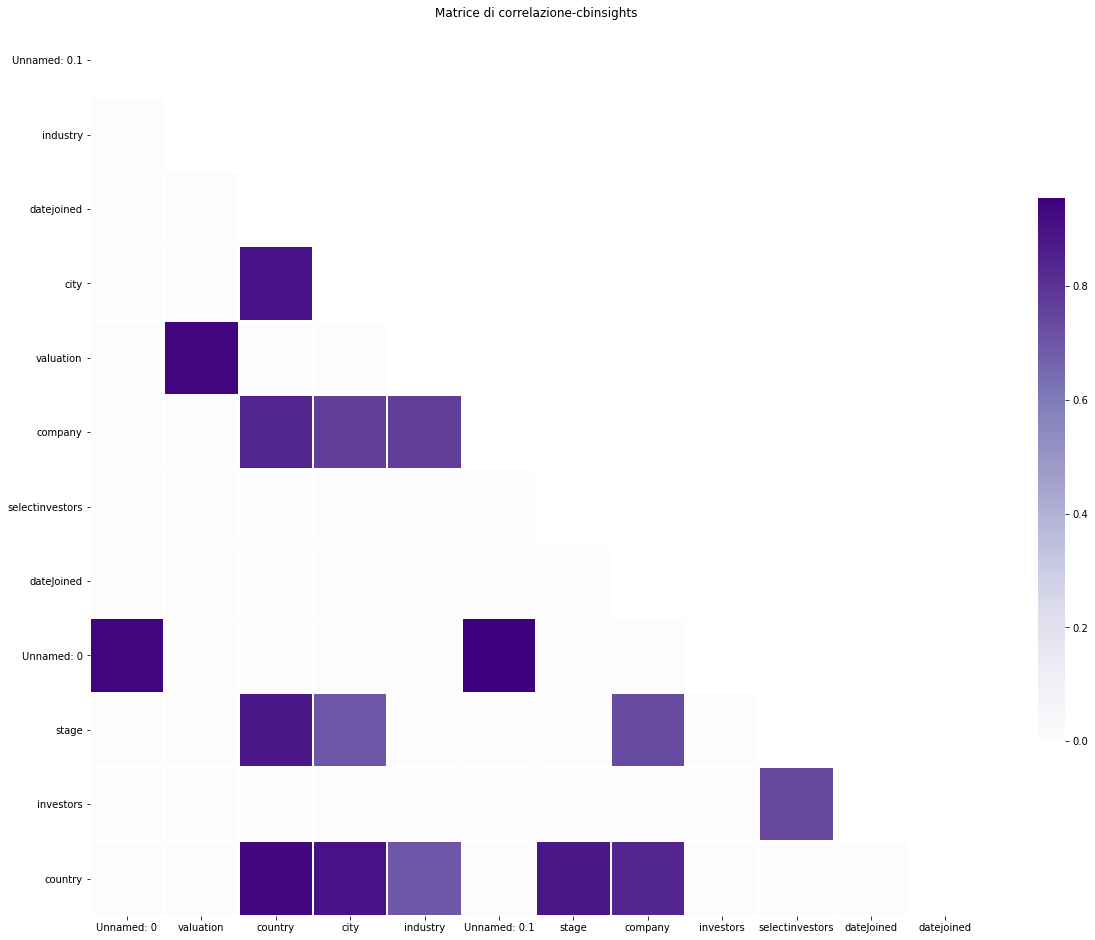

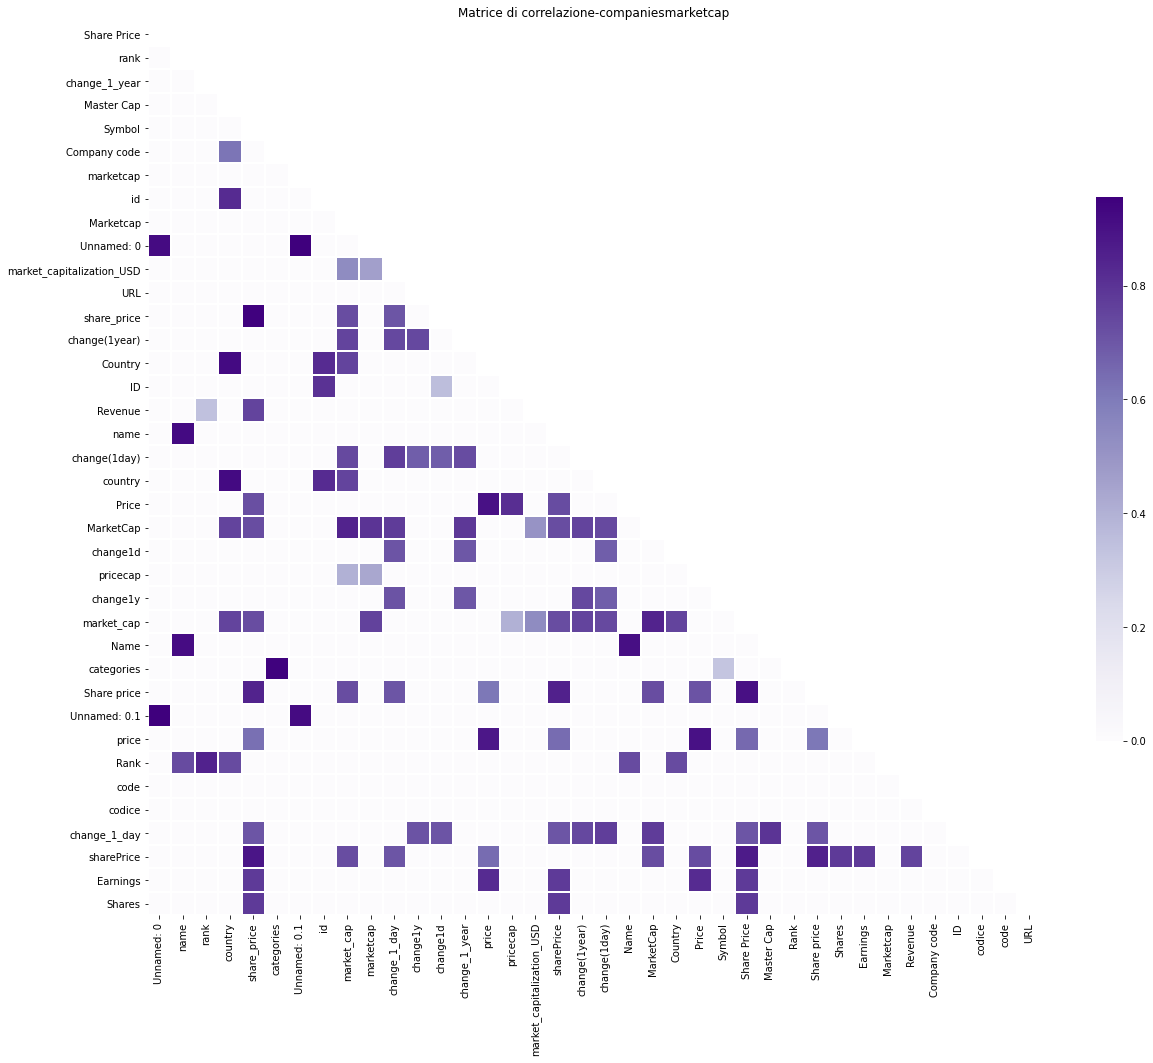

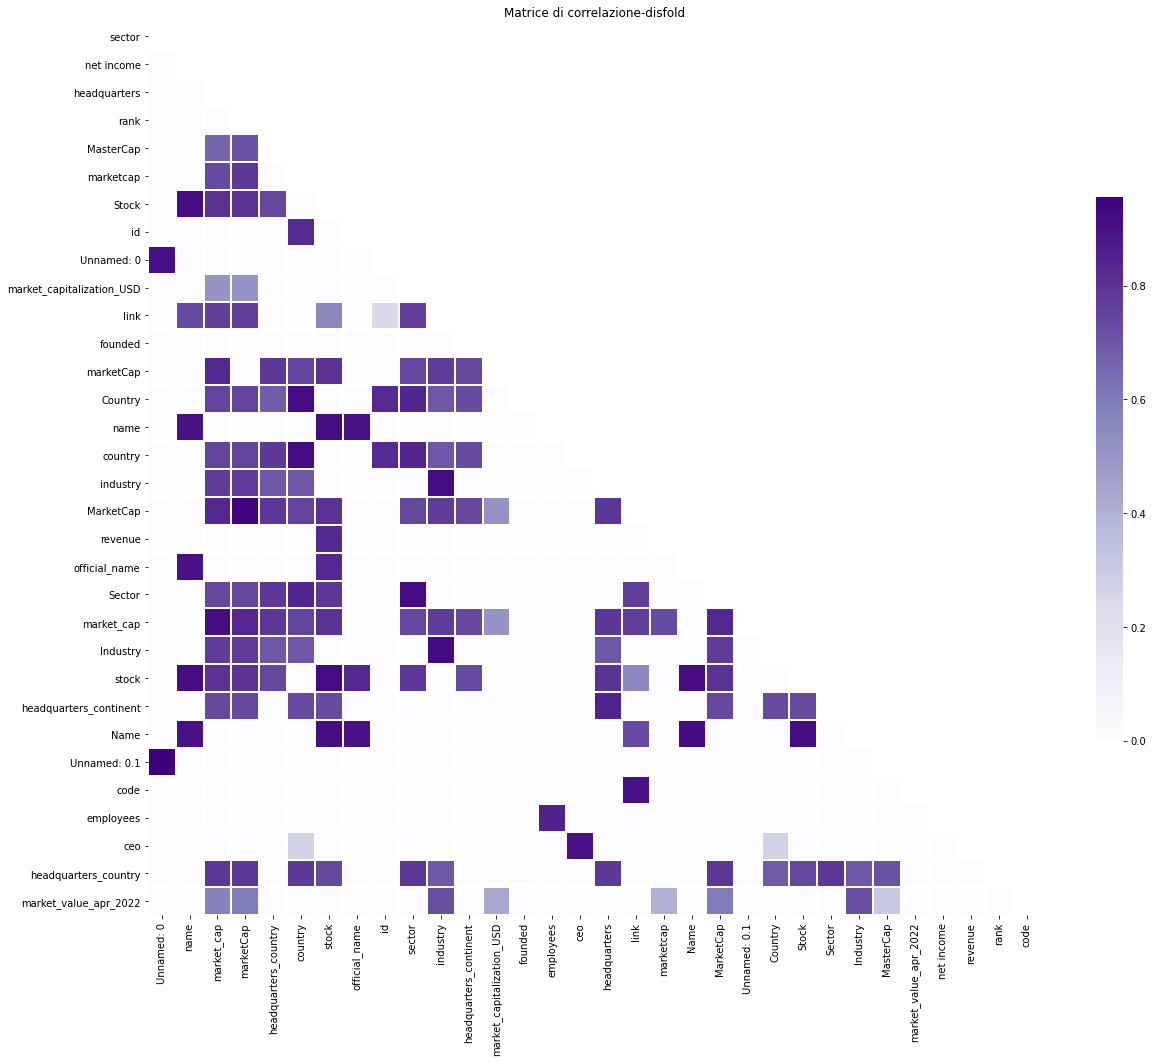

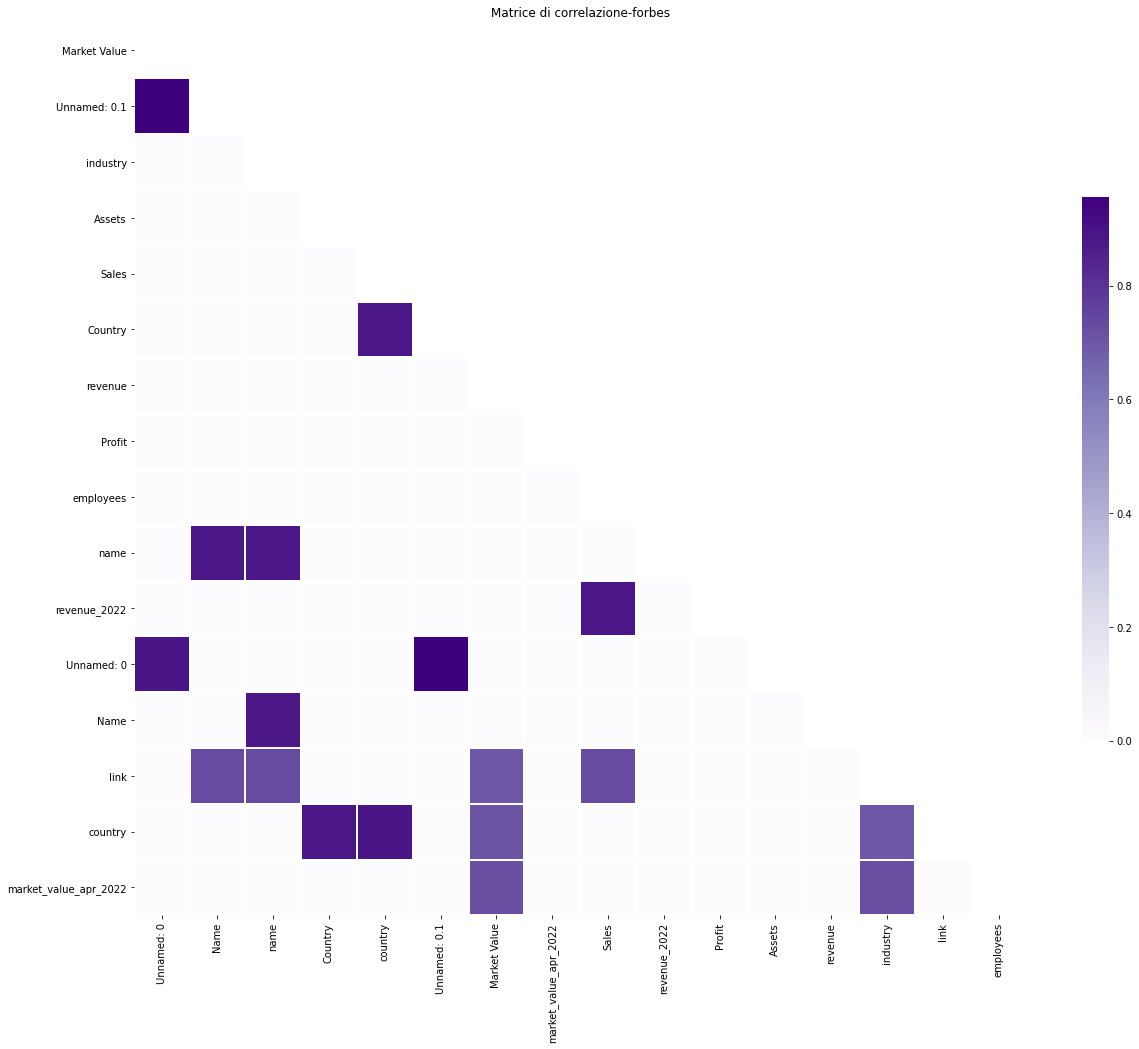

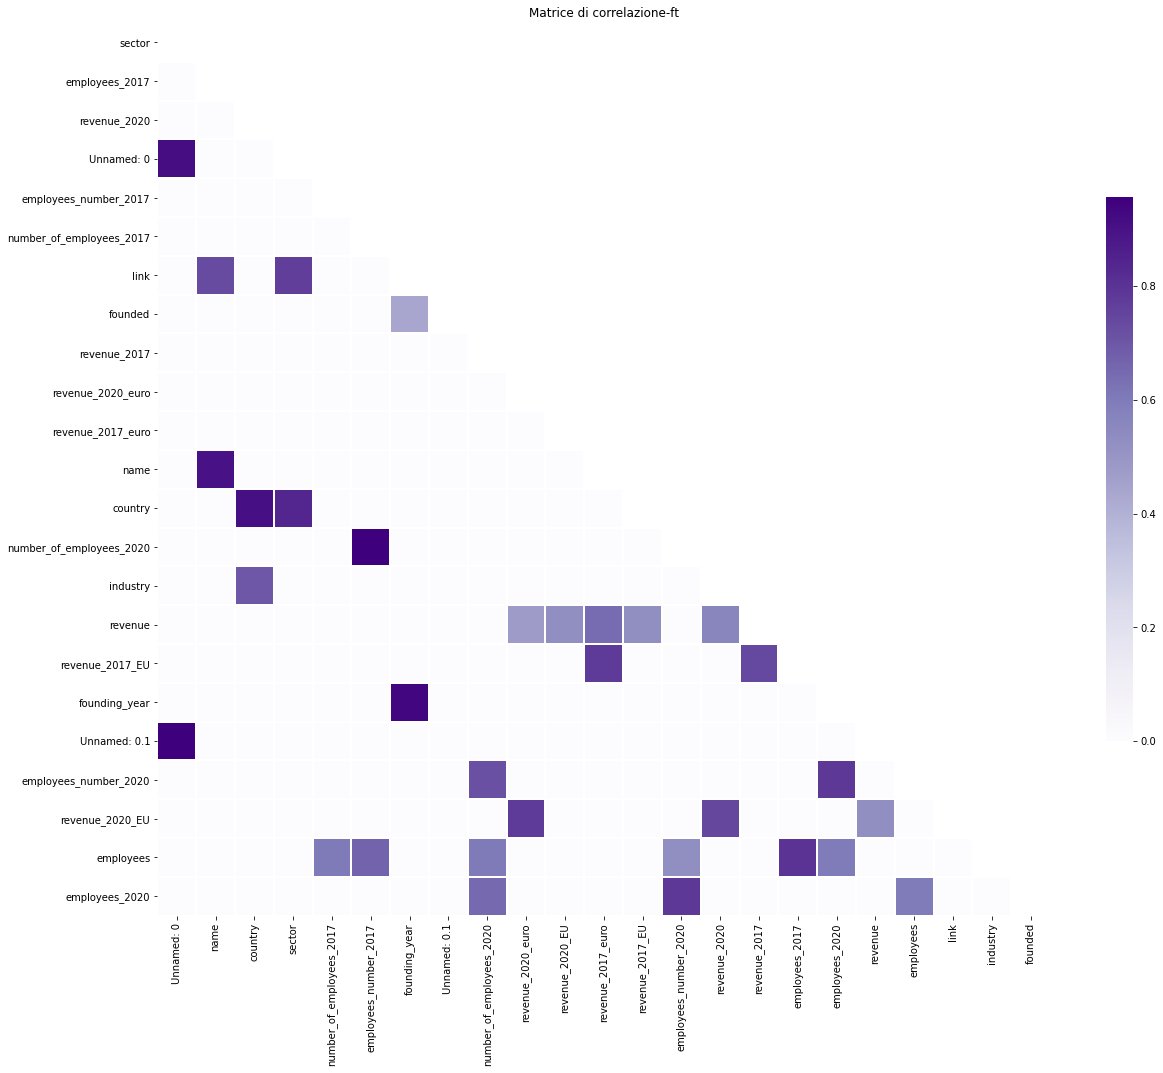

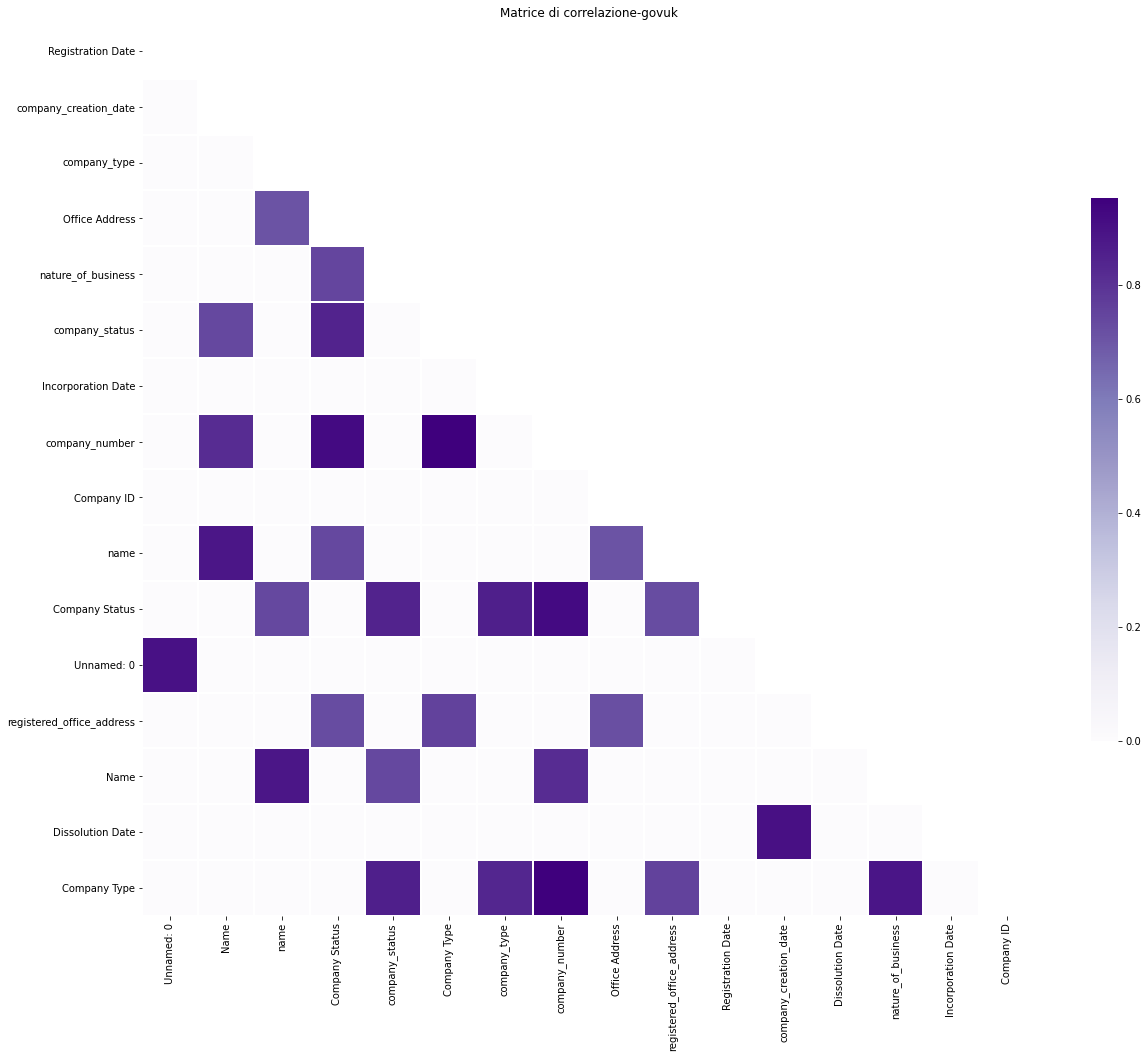

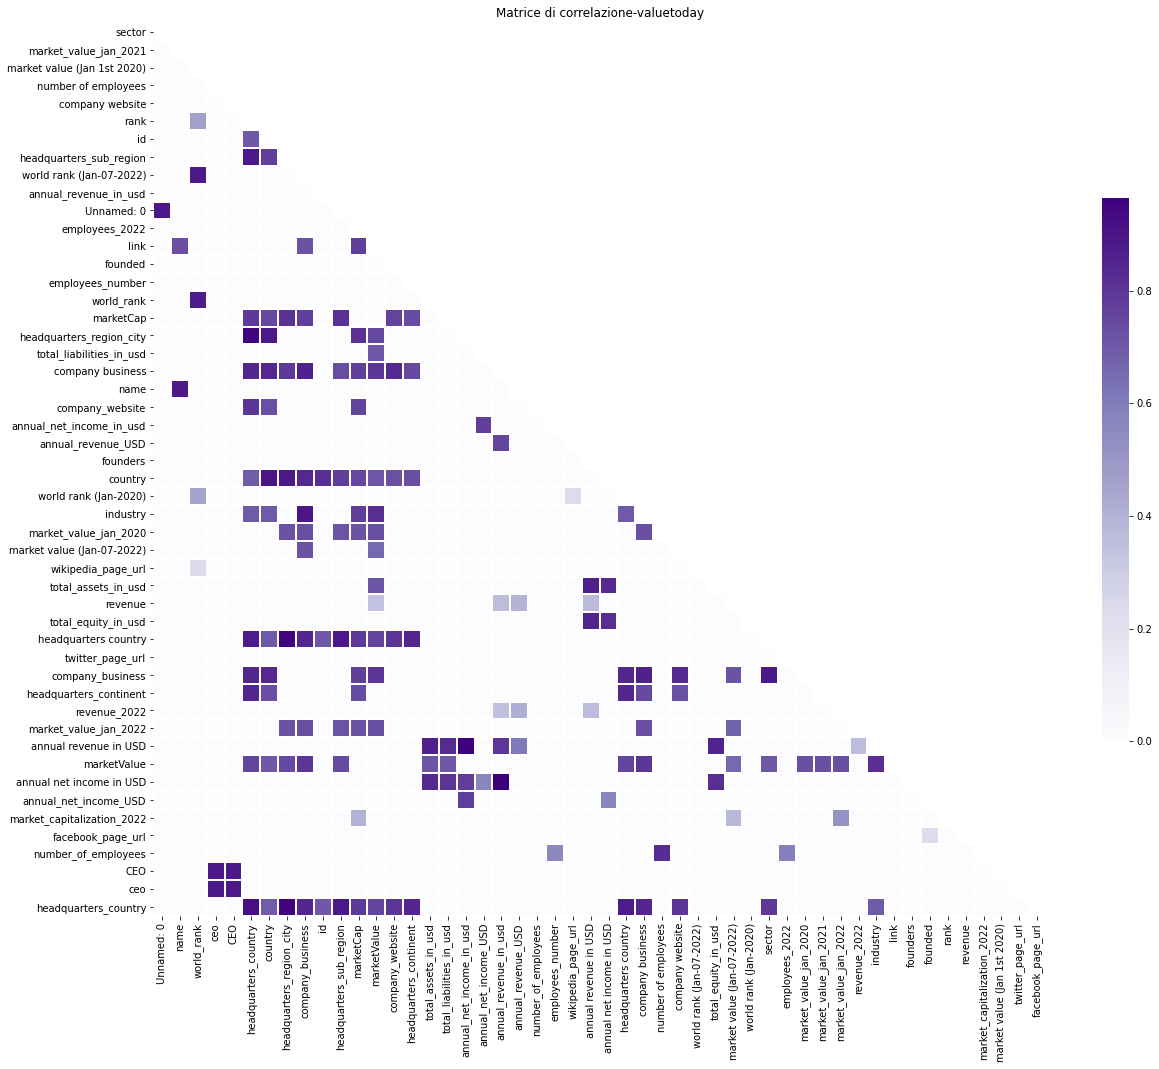

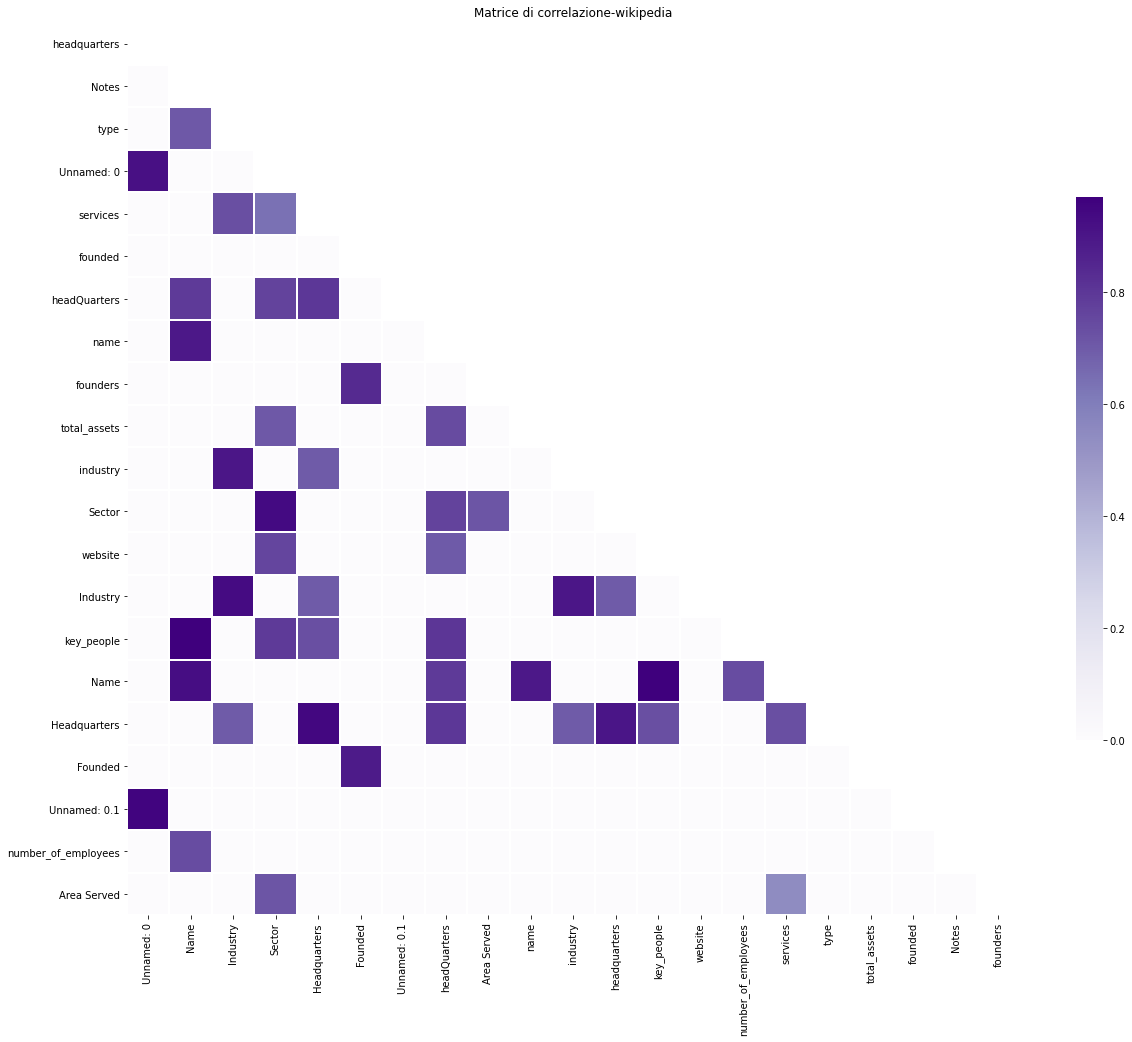

In [15]:
for cluster, correlation_matrix in correlation_matrix_cluster.items():
    df = pd.DataFrame(correlation_matrix)
    plot_correlation(df, base_path=plot_path, title="Matrice di correlazione-" + cluster)